In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
min_samples = 5
min_cluster_size = min_samples
mst = np.load("mst.npy")
data = np.load("data.npy")

## Check API and plots

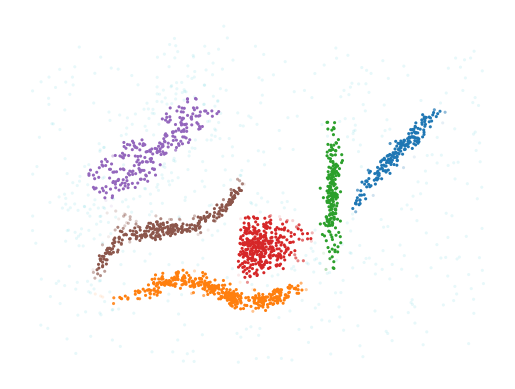

In [9]:
from plscan import PLSCAN

    
c = PLSCAN(min_cluster_size=5.0).fit(mst)
plt.scatter(
    *data.T,
    c=c.labels_ % 10,
    alpha=np.maximum(0.1, c.probabilities_),
    s=5,
    linewidth=0,
    cmap="tab10",
)
plt.axis("off")
plt.show()

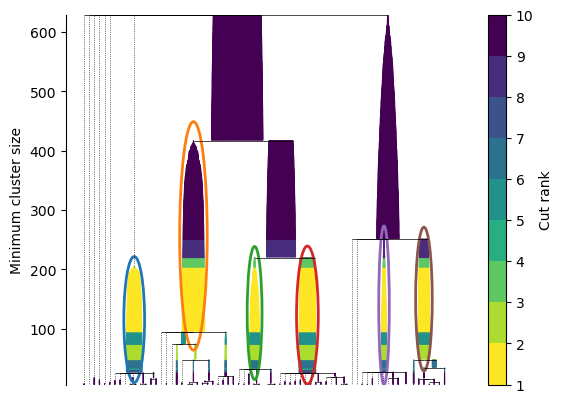

In [12]:
c.leaf_tree_.plot(select_clusters=True)
plt.show()

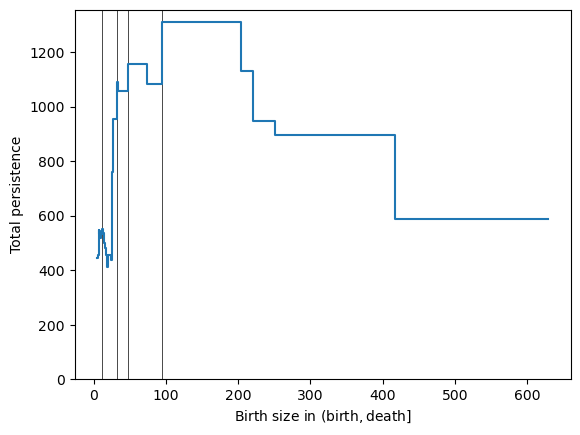

In [13]:
layers, peaks = c.cluster_layers(
    # min_size=16.0, # min cluster size threshold
    # max_size=80,   # max cluster size threshold
    # height=600,    # persistence threshold
    # threshold=25,  # persistence difference between the peak and neighbors
    n_peaks=4,     # keep only the n most persistent peaks after all thresholds
)

c.persistence_trace_.plot()
plt.vlines(list(zip(*layers))[0], *plt.ylim(), color="k", linewidth=0.5, zorder=1)
# plt.xlim([0, 125])
plt.show()

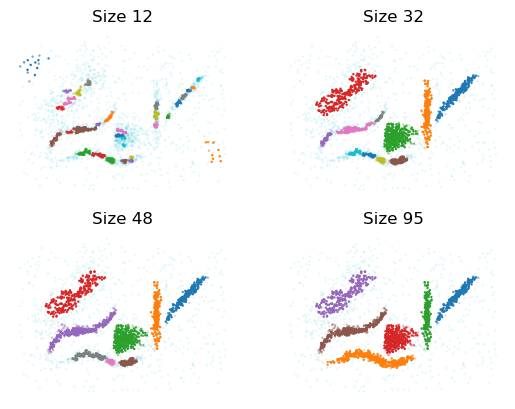

In [14]:
n_rows = int(np.ceil(np.sqrt(len(layers))))
n_cols = n_rows
plt.figure()
for i, (size, labels, probs) in enumerate(layers):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(
        *data.T,
        c=labels % 10,
        alpha=np.maximum(0.1, probs),
        s=3,
        linewidth=0,
        cmap="tab10",
    )
    plt.title(f"Size {int(size)}")
    plt.axis("off")
plt.show()

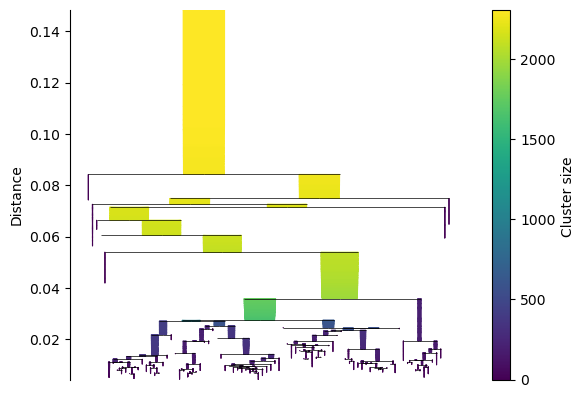

In [15]:
c.condensed_tree_.plot(distance_ranks=False)
plt.show()

In [16]:
from plscan.api import *

selected_clusters = c.selected_clusters_
trace = c._persistence_trace
sorted_mst = c._minimum_spanning_tree
condensed_tree = c._condensed_tree
leaf_tree = c._leaf_tree
linkage_tree = c._linkage_tree
sample_weights = None
min_cluster_size = c.min_cluster_size
max_cluster_size = c.max_cluster_size

In [24]:
%%timeit
linkage_tree = compute_linkage_tree(sorted_mst, sample_weights=sample_weights)

19.4 μs ± 872 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
%%timeit
condensed_tree = compute_condensed_tree(
    linkage_tree,
    sorted_mst,
    min_cluster_size=min_cluster_size,
    max_cluster_size=max_cluster_size,
    sample_weights=sample_weights,
)

10.3 μs ± 251 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [19]:
%%timeit
leaf_tree = compute_leaf_tree(condensed_tree, min_cluster_size=min_cluster_size)

1.92 μs ± 29.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [20]:
%%timeit
trace = compute_bi_persistence(leaf_tree, condensed_tree)

35.8 μs ± 286 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
%%timeit
trace = compute_size_persistence(leaf_tree)

2.64 μs ± 24.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [22]:
%%timeit
selected_clusters = most_persistent_clusters(leaf_tree, trace)

6.43 μs ± 26.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [23]:
%%timeit
labels = compute_cluster_labels(leaf_tree, condensed_tree, selected_clusters)

4.34 μs ± 16.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
